In [44]:
import numpy as np 
import pandas as pd 

plt.rcParams["font.family"] = "Heiti TC"

df_sales = pd.read_csv('data/order.csv')
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围（格式转换前）
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转换日期格式
df_sales["总价"] = df_sales["单价"] * df_sales["数量"]
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))#显示日期范围

日期范围: 1/1/2021 10:11 ~ 9/9/2020 9:20
日期范围: 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


In [12]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

日期范围: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


In [13]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')] #构建仅含头三个月数据的数据集
df_sales_3m.reset_index(drop=True) #重置索引

订单号     产品码                消费日期           产品说明  数量     单价    用户码  \
0      536374   21258 2020-06-01 09:09:00        五彩玫瑰五支装  32  10.95  15100   
1      536376   22114 2020-06-01 09:32:00       茉莉花白色25枝  48   3.45  15291   
2      536376   21733 2020-06-01 09:32:00  教师节向日葵3枝尤加利5枝  64   2.55  15291   
3      536378   22386 2020-06-01 09:37:00       百合粉色10花苞  10   1.95  14688   
4      536378  85099C 2020-06-01 09:37:00       橙黄香槟色康乃馨  10   1.95  14688   
...       ...     ...                 ...            ...  ..    ...    ...   
14837  545190   22937 2020-08-29 15:32:00         产品说明掩码   6  18.00  15656   
14838  545190   22722 2020-08-29 15:32:00         产品说明掩码   4  39.50  15656   
14839  545190   22457 2020-08-29 15:32:00         产品说明掩码  60   3.00  15656   
14840  545190   22464 2020-08-29 15:32:00         产品说明掩码  12  25.00  15656   
14841  545190   22423 2020-08-29 15:32:00         产品说明掩码   1  12.75  15656   

       城市      总价  
0      北京  350.40  
1      上海  165.60  
2      上海  163.20  
3      北京   19.50  
4      北京   19.50  
...    ..     ...  
14837  苏州  108.00  
14838  苏州  158.00  
14839  苏州  180.00  
14840  苏州  300.00  
14841  苏州   12.75  

[14842 rows x 9 columns]

In [14]:
df_user_LTV = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user_LTV.columns = ['用户码'] #设定字段名
df_user_LTV.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user_LTV = pd.merge(df_user_LTV, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user_LTV #显示用户表结构

用户码  R值   F值        M值
0    15100  45    6    635.10
1    15291  35   35   1329.95
2    14688   6   85   1472.28
3    15311   5  718  12730.01
4    15862  89   64    354.23
..     ...  ..  ...       ...
365  15951   1   22    375.17
366  14745   1    7    240.60
367  15724   0    5    103.65
368  15874   0    5    584.35
369  15656   0   15    920.35

[370 rows x 4 columns]

In [15]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index() #计算每个用户整年消费总额，构建df_user_1y对象
df_user_1y.columns = ['用户码','年度LTV'] #设定字段名
df_user_1y.head() #显示头几行数据
df_LTV = pd.merge(df_user_LTV, df_user_1y, on='用户码', how='left') #构建整体LTV训练数据集
df_LTV #显示df_LTV

用户码  R值   F值        M值     年度LTV
0    15100  45    6    635.10    635.10
1    15291  35   35   1329.95   4596.51
2    14688   6   85   1472.28   4470.65
3    15311   5  718  12730.01  58352.77
4    15862  89   64    354.23    659.73
..     ...  ..  ...       ...       ...
365  15951   1   22    375.17    375.17
366  14745   1    7    240.60   1167.16
367  15724   0    5    103.65    212.30
368  15874   0    5    584.35   4330.67
369  15656   0   15    920.35   1425.90

[370 rows x 5 columns]

#### 特征集

In [16]:
X = df_LTV.drop(['用户码','年度LTV'],axis=1) #特征集
X.head() #显示特征集

R值   F值        M值
0  45    6    635.10
1  35   35   1329.95
2   6   85   1472.28
3   5  718  12730.01
4  89   64    354.23

#### 标签集

In [17]:
y = df_LTV['年度LTV'] #标签集
y.head() #显示标签集

0      635.10
1     4596.51
2     4470.65
3    58352.77
4      659.73
Name: 年度LTV, dtype: float64

#### 拆分训练集、验证集和测试集

In [90]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)

#### 线性回归模型、决策树模型和随机森林模型

In [19]:
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
from sklearn.ensemble import RandomForestRegressor #导入随机森林回归模型
model_lr = LinearRegression() #创建线性回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_rfr = RandomForestRegressor() #创建随机森林回归模型

#### 训练模型

In [20]:
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_rfr.fit(X_train, y_train) #拟合随机森林模型

RandomForestRegressor()

#### 评估模型

In [21]:
y_valid_preds_lr = model_lr.predict(X_valid) #用线性回归模型预测验证集
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_rfr = model_rfr.predict(X_valid) #用随机森林模型预测验证集

In [22]:
X_valid.iloc[2] #随便选择一个数据

R值       1.00
F值     154.00
M值    1427.73
Name: 163, dtype: float64

In [23]:
print('真值:', y_valid.iloc[2])  #真值
print('线性回归预测值:', y_valid_preds_lr[2])  #线性回归模型预测值
print('决策树预测值:', y_valid_preds_dtr[2])  #决策树模型预测值
print('随机森林预测值:', y_valid_preds_rfr[2]) #随机森林模型预测值

真值: 4432.429999999991
线性回归预测值: 7474.418142488366
决策树预测值: 4074.57
随机森林预测值: 4086.1310000000026


#### 准确率

In [24]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('验证集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的R平方分数-随机森林: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

验证集上的R平方分数-线性回归: 0.4410
验证集上的R平方分数-决策树: 0.2664
验证集上的R平方分数-随机森林: 0.4721


#### 随机森林验证测试值

Text(0.5, 1.0, '实际值 vs. 预测值')

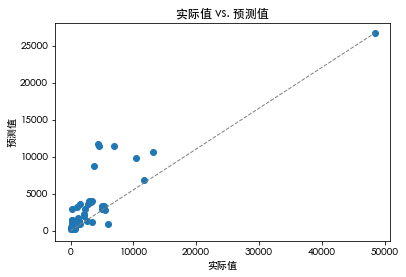

In [45]:
import matplotlib.pyplot as plt

y_test_preds = model_rfr.predict(X_test) #用模型预随机森林模型预测验证集
plt.scatter(y_test, y_test_preds) #预测值和实际值的散点图
plt.plot([0, max(y_test)], [0, max(y_test_preds)],   color='gray', lw=1, linestyle='--') #绘图
plt.xlabel('实际值') #X轴
plt.ylabel('预测值') #Y轴
plt.title('实际值 vs. 预测值') #标题

In [31]:
city = pd.get_dummies(df_sales.城市, prefix='城市')
df_sales = pd.concat([df_sales, city], axis=1)
df_sales.head()

订单号     产品码                消费日期           产品说明  数量     单价    用户码  城市  \
0  536374   21258 2020-06-01 09:09:00        五彩玫瑰五支装  32  10.95  15100  北京   
1  536376   22114 2020-06-01 09:32:00       茉莉花白色25枝  48   3.45  15291  上海   
2  536376   21733 2020-06-01 09:32:00  教师节向日葵3枝尤加利5枝  64   2.55  15291  上海   
3  536378   22386 2020-06-01 09:37:00       百合粉色10花苞  10   1.95  14688  北京   
4  536378  85099C 2020-06-01 09:37:00       橙黄香槟色康乃馨  10   1.95  14688  北京   

      总价  城市_上海  ...  城市_深圳  城市_苏州  城市_西安  城市_上海  城市_北京  城市_广州  城市_成都  城市_深圳  \
0  350.4      0  ...      0      0      0      0      1      0      0      0   
1  165.6      1  ...      0      0      0      1      0      0      0      0   
2  163.2      1  ...      0      0      0      1      0      0      0      0   
3   19.5      0  ...      0      0      0      0      1      0      0      0   
4   19.5      0  ...      0      0      0      0      1      0      0      0   

   城市_苏州  城市_西安  
0      0      0  
1      0      0  
2      0      0  
3      0      0  
4      0      0  

[5 rows x 23 columns]

## 特征选择

<AxesSubplot:>

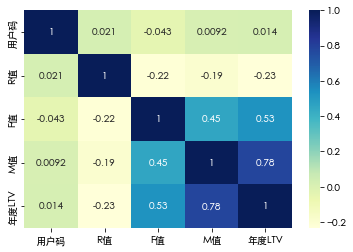

In [40]:
# 对所有的标签和特征两两显示其相关性热力图(heatmap)
import matplotlib.pyplot as plt

import seaborn as sns
sns.heatmap(df_LTV.corr(), cmap="YlGnBu", annot = True)

#### 丢弃R值

In [35]:
X_train_less_feature = X_train.drop(['R值'], axis=1) #特征训练集
X_valid_less_feature = X_valid.drop(['R值'], axis=1) #特征验证集
model_lr_less_feature = LinearRegression() #创建线性回归模型
model_lr_less_feature.fit(X_train_less_feature, y_train) #拟合线性回归模型
print('测试集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('测试集上的R平方分数-少R值特征的线性回归: %0.4f' % r2_score(y_valid, model_lr_less_feature.predict(X_valid_less_feature)))

测试集上的R平方分数-线性回归: 0.4410
测试集上的R平方分数-少R值特征的线性回归: 0.4356


#### 特征选择

In [36]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression  #导入特征选择工具
selector = SelectKBest(mutual_info_regression, k = 2) #选择最重要的两个特征
selector.fit(X, y) #用特征选择模型拟合数据集
X.columns[selector.get_support()] #输出选中的两个特征

Index(['F值', 'M值'], dtype='object')

### 特征缩放

In [37]:
from sklearn.preprocessing import StandardScaler #导入标准化缩放器
scaler = StandardScaler() #创建标准化缩放器
X_train_standard = scaler.fit_transform(X_train) #拟合并转换训练集数据
X_valid_standard = scaler.transform(X_valid) #转换验证集数据
X_test_standard = scaler.transform(X_test) #转换测试集数据

### 拟合

In [42]:
model_rfr_standard = RandomForestRegressor() #创建随机森林回归模型
model_rfr_standard.fit(X_train_standard, y_train) #拟合随机森林模型

RandomForestRegressor()

### MinMaxScaler

In [43]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
scaler = MinMaxScaler() #创建归一化缩放器
X_train_minmax = scaler.fit_transform(X_train) #拟合并转换训练集数据
X_valid_minmax = scaler.transform(X_valid) #转换验证集数据
X_test_minmax = scaler.transform(X_test) #转换测试集数据

In [47]:
model_rfr_minmax = RandomForestRegressor() #创建随机森林回归模型
model_rfr_minmax.fit(X_train_minmax, y_train) #拟合随机森林模型

RandomForestRegressor()

### 模型评估

In [48]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('验证集上的R平方分数-随机森林（无缩放）: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))
print('验证集上的R平方分数-随机森林（标准化）: %0.4f' % r2_score(y_valid, model_rfr_standard.predict(X_valid_standard)))
print('验证集上的R平方分数-随机森林（归一化）: %0.4f' % r2_score(y_valid, model_rfr_minmax.predict(X_valid_minmax)))

验证集上的R平方分数-随机森林（无缩放）: 0.4721
验证集上的R平方分数-随机森林（标准化）: 0.5011
验证集上的R平方分数-随机森林（归一化）: 0.4839


### 柱状图

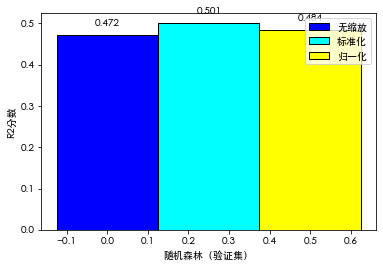

In [49]:
import numpy as np

fig, ax = plt.subplots()    
width = 0.25

# 柱子数据

bars1 = [r2_score(y_valid, model_rfr.predict(X_valid))]
bars2 = [r2_score(y_valid, model_rfr_standard.predict(X_valid_standard))]
bars3 = [r2_score(y_valid, model_rfr_minmax.predict(X_valid_minmax))]
 
# 柱状图x轴位置
r1 = np.arange(len(bars1))
r2 = [x + width for x in r1]
r3 = [x + width*2 for x in r1]
 
# 柱状图
plt.bar(r1, bars1, width = width, color = 'blue', edgecolor = 'black', capsize=7, label='无缩放')
plt.bar(r2, bars2, width = width, color = 'cyan', edgecolor = 'black', capsize=7, label='标准化')
plt.bar(r3, bars3, width = width, color = 'yellow', edgecolor = 'black', capsize=7, label='归一化')

# 布局
plt.ylabel('R2分数')
plt.xlabel('随机森林（验证集）')
plt.legend()

# 数值标签
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i/50+x[i], round(y[i], 3)+0.02, round(y[i], 3), ha = 'center')
addlabels(r1, bars1)
addlabels(r2, bars2)
addlabels(r3, bars3)

# 绘图
plt.show()

In [50]:
# 把多分类字段转换为二分类虚拟变量 
category_features = ['城市'] #要转换的特征列表
df_sales = pd.get_dummies(df_sales, drop_first=True, columns=category_features) #创建哑变量
df_sales #显示数据

订单号     产品码                消费日期           产品说明  数量      单价    用户码  \
0      536374   21258 2020-06-01 09:09:00        五彩玫瑰五支装  32   10.95  15100   
1      536376   22114 2020-06-01 09:32:00       茉莉花白色25枝  48    3.45  15291   
2      536376   21733 2020-06-01 09:32:00  教师节向日葵3枝尤加利5枝  64    2.55  15291   
3      536378   22386 2020-06-01 09:37:00       百合粉色10花苞  10    1.95  14688   
4      536378  85099C 2020-06-01 09:37:00       橙黄香槟色康乃馨  10    1.95  14688   
...       ...     ...                 ...            ...  ..     ...    ...   
87175  581585   21684 2021-06-09 12:31:00         产品说明掩码  12    5.00  15804   
87176  581585   22398 2021-06-09 12:31:00         产品说明掩码  12  499.00  15804   
87177  581585   23328 2021-06-09 12:31:00         产品说明掩码   4   58.00  15804   
87178  581585   23145 2021-06-09 12:31:00         产品说明掩码  12   88.90  15804   
87179  581585   22466 2021-06-09 12:31:00         产品说明掩码  12   78.00  15804   

           总价  城市_北京  城市_广州  城市_成都  城市_深圳  城市_苏州  城市_西安  
0       350.4      1      0      0      0      0      0  
1       165.6      0      0      0      0      0      0  
2       163.2      0      0      0      0      0      0  
3        19.5      1      0      0      0      0      0  
4        19.5      1      0      0      0      0      0  
...       ...    ...    ...    ...    ...    ...    ...  
87175    60.0      0      0      0      1      0      0  
87176  5988.0      0      0      0      1      0      0  
87177   232.0      0      0      0      1      0      0  
87178  1066.8      0      0      0      1      0      0  
87179   936.0      0      0      0      1      0      0  

[87180 rows x 14 columns]

### 特征拟合

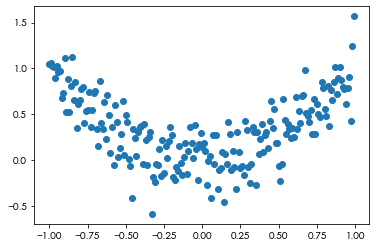

In [51]:
import pandas as pd #导入Pandas
import numpy as np #导入NumPy
import matplotlib.pyplot as plt #导入绘图工具
df = pd.read_csv('data/feature.csv') #导入数据
plt.scatter(df.X, df.Y) #X，Y散点图

#### 线性回归拟合

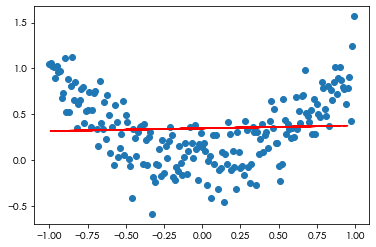

In [58]:
from sklearn.model_selection import train_test_split #导入train_test_split 
df_x = df['X'].to_frame() #特征集
df_y = df['Y'] #标签集
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.3, random_state = 0) #拆分数据集
from sklearn.linear_model import LinearRegression #导入LinearRegression
model = LinearRegression() #创建模型
model.fit(X_train, y_train) #拟合模型
plt.scatter(df.X, df.Y) #散点图
plt.plot(X_test, model.predict(X_test),linestyle='--', color = 'red') #显示拟合曲线

#### 多项式拟合

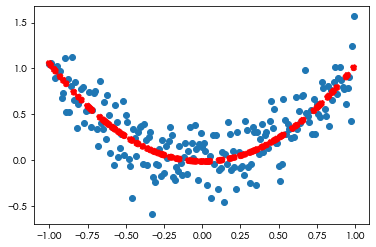

In [57]:
X2_train = X_train.copy() #新特征训练集
X2_test = X_test.copy() #新特征测试集
X2_train['X2'] = X2_train['X']**2 #构建新特征X2
X2_test['X2'] = X2_test['X']**2 #构建新特征X2
model2 = LinearRegression() #创建新模型
model2.fit(X2_train, y_train) #拟合新模型
plt.scatter(df.X, df.Y) #散点图
plt.scatter(X_test, model2.predict(X2_test), linestyle='--', color = 'red') #新拟合函数曲线

### 决策树裁剪

In [61]:
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_dtr_cut = DecisionTreeRegressor(max_depth=3) #创建深度为3的决策树回归模型
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_dtr_cut.fit(X_train, y_train) #拟合深度为3的决策树模型
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_dtr_cut = model_dtr_cut.predict(X_valid) #用深度为2的决策树模型预测验证集
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('训练集上的R平方分数-决策树: %0.4f' % r2_score(y_train, model_dtr.predict(X_train)))
print('训练集上的R平方分数-深度为3的决策树: %0.4f' % r2_score(y_train, model_dtr_cut.predict(X_train)))
print('测试集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('测试集上的R平方分数-深度为3的决策树: %0.4f' % r2_score(y_valid, model_dtr_cut.predict(X_valid)))

训练集上的R平方分数-决策树: 1.0000
训练集上的R平方分数-深度为3的决策树: 0.8045
测试集上的R平方分数-决策树: 0.2840
测试集上的R平方分数-深度为3的决策树: 0.4870


### 正则化

In [65]:
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
model_lr = LinearRegression() #创建线性回归模型
model_lasso = Lasso() #创建Lasso回归模型
model_ridge = Ridge() #创建Ridge回归模型
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_lasso.fit(X_train, y_train) #拟合Lasso回归模型
model_ridge.fit(X_train, y_train) #拟合Ridge回归模型
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('训练集上的R平方分数-线性回归: %0.4f' % r2_score(y_train, model_lr.predict(X_train)))
print('训练集上的R平方分数-Lasso回归: %0.4f' % r2_score(y_train, model_lasso.predict(X_train)))
print('训练集上的R平方分数-Ridge回归: %0.4f' % r2_score(y_train, model_ridge.predict(X_train)))
print('测试集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('测试集上的R平方分数-Lasso回归: %0.4f' % r2_score(y_valid, model_lasso.predict(X_valid)))
print('测试集上的R平方分数-Ridge回归: %0.4f' % r2_score(y_valid, model_ridge.predict(X_valid)))

训练集上的R平方分数-线性回归: 0.6923
训练集上的R平方分数-Lasso回归: 0.6923
训练集上的R平方分数-Ridge回归: 0.6923
测试集上的R平方分数-线性回归: 0.4410
测试集上的R平方分数-Lasso回归: 0.4410
测试集上的R平方分数-Ridge回归: 0.4410


### K折

In [71]:
from sklearn.model_selection import KFold #导入K折工具
from sklearn.metrics import r2_score #导入R2分数评估工具
kf5 = KFold(n_splits=5, shuffle=False) #5折验证
 
for i, (train_index, test_index) in enumerate(kf5.split(df_LTV), 1): 
    X_train = df_LTV.iloc[train_index].drop(['年度LTV'],axis=1) #训练集X
    X_test = df_LTV.iloc[test_index].drop(['年度LTV'],axis=1) #验证集X
    y_train = df_LTV.iloc[train_index]['年度LTV'] #训练集y
    y_test = df_LTV.loc[test_index]['年度LTV'] #验证集y 
    model_lr.fit(X_train, y_train) #训练模型
    print(f"第{i}折验证集R2分数：{r2_score(y_test, model_lr.predict(X_test))}") 

第1折验证集R2分数：0.5342671796732407
第2折验证集R2分数：0.5614034587084156
第3折验证集R2分数：0.5045251868789532
第4折验证集R2分数：-1.6259947565379553
第5折验证集R2分数：0.026149924321112406


#### 交叉验证cross_val_score

In [72]:
from sklearn.model_selection import cross_val_score # 导入交叉验证工具
# from sklearn.metrics import mean_squared_error #平均绝对误差
model_lr = LinearRegression() #线性回归模型
scores = cross_val_score(model_lr, #线性回归
                  X_train, #特征集
                  y_train, #标签集
                  cv=5, # 五折验证
                  scoring = 'neg_mean_absolute_error') #平均绝对误差
for i, score in enumerate(scores, 1):
    print(f"第{i}折验证集平均绝对误差： {-score}")

第1折验证集平均绝对误差： 3565.249168643678
第2折验证集平均绝对误差： 1689.548163875083
第3折验证集平均绝对误差： 1377.2896990108964
第4折验证集平均绝对误差： 1117.957729234401
第5折验证集平均绝对误差： 1843.016043702997


### 网格搜索：直到找到最优的参数

In [92]:
model_rfr = RandomForestRegressor() # 随机森林模型

# 对随机森林算法进行参数优化
rfr_param_grid = {'bootstrap': [True, False],
                 'max_depth': [10, 50, 100, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [50, 500, 2000]}

In [93]:
from sklearn.model_selection import GridSearchCV # 导入网格搜索工具
model_rfr_gs = GridSearchCV(model_rfr,
                            param_grid = rfr_param_grid, cv=3,
                            scoring="r2", n_jobs= 10, verbose = 1)
model_rfr_gs.fit(X_train, y_train) # 用优化后的参数拟合训练数据集

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=10,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 50, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 500, 2000]},
             scoring='r2', verbose=1)

In [94]:
print(" 最佳参数组合:", model_rfr_gs.best_params_)

 最佳参数组合: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [95]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块

print('训练集上的R平方分数-调参后的随机森林: %0.4f' % r2_score(y_train, model_rfr_gs.predict(X_train)))
print('测试集上的R平方分数-调参后的随机森林: %0.4f' % r2_score(y_valid, model_rfr_gs.predict(X_valid)))

训练集上的R平方分数-调参后的随机森林: 0.7397
测试集上的R平方分数-调参后的随机森林: 0.5994
